# FITSファイルを見るためのPythonコード

tarアーカイブでダウンロードした場合，解凍する作業が必要．

In [1]:
import tarfile
import gzip
import glob
from matplotlib.animation import FuncAnimation
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
import os
from matplotlib.colors import LogNorm
import numpy as np

In [2]:
# 圧縮ファイルのパスと出力フォルダ
tar_path = '/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/Raw data/20220613.kcor_sub.fits.tar'
output_folder = '/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/Raw data'

## ファイルの解凍

In [3]:
def extract_fits_files(tar_path, extract_folder):
    """FITSファイルを圧縮ファイルから解凍し、展開する."""
    if not os.path.exists(extract_folder):
        os.makedirs(extract_folder)

    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_folder)
        print(f"Files extracted to: {extract_folder}")

    gz_files = []
    for root, dirs, files in os.walk(extract_folder):
        for file in files:
            if file.endswith('.fts.gz'):
                gz_files.append(os.path.join(root, file))

    fts_files = []
    for gz_file in gz_files:
        fts_file = gz_file[:-3]  # .gzを取り除く
        with gzip.open(gz_file, 'rb') as gz:
            with open(fts_file, 'wb') as fts:
                fts.write(gz.read())
        fts_files.append(fts_file)

    print("Decompressed FTS files:", fts_files)
    return fts_files

In [4]:
# 1. FITSファイルの解凍
fts_files = extract_fits_files(tar_path, output_folder)

Files extracted to: /home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output
Decompressed FTS files: ['/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/20220613_024315_kcor_minus_023308_good.fts', '/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/20220613_024818_kcor_minus_023812_good.fts', '/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/20220613_005200_kcor_minus_004153_good.fts', '/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/20220613_022805_kcor_minus_021758_good.fts', '/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/20220613_042423_kcor_minus_041417_good.fts', '/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/20220613_001636_kcor_minus_000629_good.fts', '/home/kinno-7010/Research/M

## FITSデータをプロット

### 画像として出力

In [8]:
def read_fits_file(fits_path):
    """FITSファイルを読み込み、データとヘッダーを返す."""
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def calculate_statistics(data, exclude_zeros=True):
    """データの統計情報を計算."""
    if exclude_zeros:
        data = data[data > 0]  # ゼロ以下を除外
    return {
        "min": np.min(data),
        "max": np.max(data),
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data),
    }


def visualize_fits_data(data, header, statistics):
    """FITSデータを可視化し、X, Y の単位を太陽半径に変換."""
    # 太陽中心座標と太陽半径（ピクセル単位）
    solar_x = header.get('CRPIX1', data.shape[1] // 2) - 1  # FITS index starts at 1
    solar_y = header.get('CRPIX2', data.shape[0] // 2) - 1
    solar_radius = header.get('R_SUN', 0)

    # ピクセルスケールを太陽半径に変換
    if solar_radius > 0:
        pixel_to_rsun = 1 / solar_radius  # 1ピクセルあたりの太陽半径
    else:
        raise ValueError("Invalid solar radius in header.")

    # データの統計情報
    data_mean = statistics["mean"]
    data_std = statistics["std"]

    # カラーバーの範囲を設定
    custom_vmin = data_mean - 2 * data_std
    custom_vmax = data_mean + 5 * data_std

    # プロット
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # X, Y 軸の範囲を太陽半径に変換
    extent = [
        -solar_x * pixel_to_rsun, (data.shape[1] - solar_x) * pixel_to_rsun,
        -solar_y * pixel_to_rsun, (data.shape[0] - solar_y) * pixel_to_rsun
    ]

    im = ax.imshow(data, cmap='gray', origin='lower', vmin=custom_vmin, vmax=custom_vmax, extent=extent)

    # 太陽中心を通る円を描画
    if solar_radius > 0:
        circle = Circle((0, 0), solar_radius * pixel_to_rsun, color='red', fill=False, lw=1.5, label="Solar Disk")
        ax.add_patch(circle)

    # 特定の座標を通る円の描画
    custom_radius = np.sqrt((0 - solar_x) ** 2 + (solar_y - solar_y) ** 2) * pixel_to_rsun
    circle = Circle((0, 0), custom_radius, color='white', fill=False, linestyle='--', lw=1.0, label="Custom Radius")
    ax.add_patch(circle)
    

    # 太陽中心の赤い点を描画
    ax.scatter(0, 0, color='red', s=50, label="Solar Center")
    
        # グリッドの追加 (0.5 Rsごと)
    grid_spacing = 0.5  # グリッド間隔
    x_min, x_max = int(extent[0] // grid_spacing) * grid_spacing, int(extent[1] // grid_spacing) * grid_spacing
    y_min, y_max = int(extent[2] // grid_spacing) * grid_spacing, int(extent[3] // grid_spacing) * grid_spacing
    ax.set_xticks(np.arange(x_min+grid_spacing, x_max + grid_spacing, grid_spacing))
    ax.set_yticks(np.arange(y_min+grid_spacing, y_max + grid_spacing, grid_spacing))
    ax.grid(color='white', linestyle='--', linewidth=0.1)
    

    # カラーバー設定
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="3%", pad=0.1)
    # plt.colorbar(im, cax=cax, label="Brightness (B/Bsun)")

    # タイトルとラベル
    ax.set_title("White Light Level-2 pB Data (Subtraction)", fontsize=20)
    # ax.set_xlabel("X [Solar Radius $R_\\odot$]", fontsize=16)
    # ax.set_ylabel("Y [Solar Radius $R_\\odot$]", fontsize=16)
    ax.axis('off')
    

    # 凡例表示
    # ax.legend()
    plt.show()



Statistics: {'min': np.float32(1.7763568e-15), 'max': np.float32(1.335975e-07), 'mean': np.float32(1.0915353e-09), 'median': np.float32(4.4084664e-10), 'std': np.float32(4.93383e-09)}
fts_files[0]: /home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/20220613_024315_kcor_minus_023308_good.fts


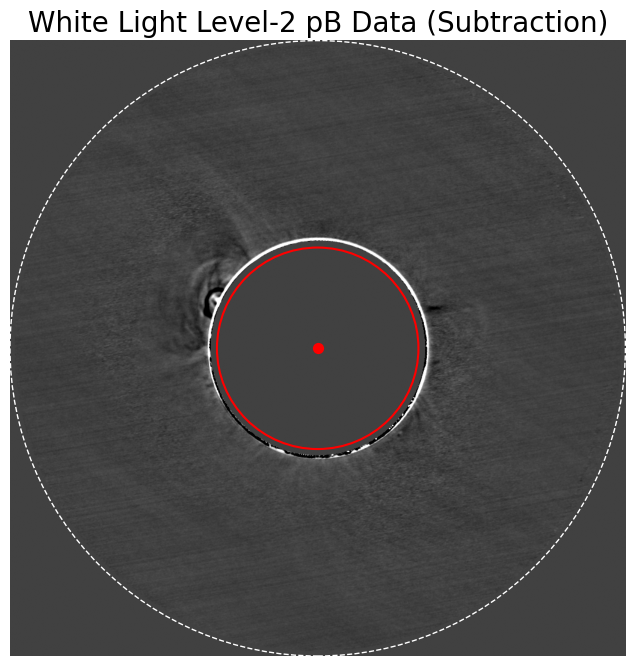

In [9]:

# 2. 最初のFITSファイルを読み込む
if fts_files:
    data, header = read_fits_file(fts_files[0])

    # 3. 統計情報の計算
    stats = calculate_statistics(data)
    print(f"Statistics:", stats)
    print("fts_files[0]:", fts_files[0])

    # 4. 可視化
    visualize_fits_data(data, header, stats)

### 動画として出力

In [11]:
def read_fits_file(fits_path):
    """FITSファイルを読み込み、データとヘッダーを返す."""
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def calculate_statistics(data, exclude_zeros=False):
    """データの統計情報を計算."""
    if exclude_zeros:
        data = data[data > 0]  # ゼロ以下を除外
    return {
        "min": np.min(data),
        "max": np.max(data),
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data),
    }

def draw_frame(data, header, ax):
    """単一フレームを描画."""
    # 太陽中心と半径
    solar_x = header.get('CRPIX1', data.shape[1] // 2) - 1
    solar_y = header.get('CRPIX2', data.shape[0] // 2) - 1
    solar_radius = header.get('R_SUN', 0)

    # ピクセルスケールを太陽半径に変換
    pixel_to_rsun = 1 / solar_radius if solar_radius > 0 else 1

    # データの統計情報を計算
    stats = calculate_statistics(data)
    data_min, data_max, data_mean,data_median, data_std = stats["min"], stats["max"], stats["mean"], stats["median"], stats["std"]
    custom_vmin = data_mean - 2 * data_std
    custom_vmax = data_mean + 5 * data_std
    # print("data_min:", data_min)
    # print("data_max:", data_max)
    # print("data_mean:", data_mean)
    # print("data_median:", data_median)
    # print("data_std:", data_std)
    

    # 軸の設定
    extent = [
        -solar_x * pixel_to_rsun, (data.shape[1] - solar_x) * pixel_to_rsun,
        -solar_y * pixel_to_rsun, (data.shape[0] - solar_y) * pixel_to_rsun
    ]
    ax.clear()
    im = ax.imshow(data, cmap='gray', origin='lower', vmin=custom_vmin, vmax=custom_vmax, extent=extent)

    # 太陽中心と円を描画
    ax.scatter(0, 0, color='red', s=50, label="Solar Center")
    if solar_radius > 0:
        circle = Circle((0, 0), solar_radius * pixel_to_rsun, color='red', fill=False, lw=1.5, label="Solar Disk")
        ax.add_patch(circle)
        
        # 特定の座標を通る円の描画
    custom_radius = np.sqrt((0 - solar_x) ** 2 + (solar_y - solar_y) ** 2) * pixel_to_rsun
    circle = Circle((0, 0), custom_radius, color='white', fill=False, linestyle='--', lw=1.0, label="Custom Radius")
    ax.add_patch(circle)

    # グリッドの描画 (0.5 Rsごと)
    grid_spacing = 0.5
    x_min, x_max = int(extent[0] // grid_spacing) * grid_spacing, int(extent[1] // grid_spacing) * grid_spacing
    y_min, y_max = int(extent[2] // grid_spacing) * grid_spacing, int(extent[3] // grid_spacing) * grid_spacing
    ax.set_xticks(np.arange(x_min+grid_spacing, x_max + grid_spacing, grid_spacing))
    ax.set_yticks(np.arange(y_min+grid_spacing, y_max + grid_spacing, grid_spacing))
    ax.grid(color='white', linestyle='--', linewidth=0.1)

    # タイトルと軸ラベル
    file_name = os.path.basename(header.get('FILENAME', ''))
    date_obs = header.get('DATE-OBS', 'Unknown Time')  # 観測時間を取得
    ax.set_title(f"Time: {date_obs}", fontsize=12)  # タイトルに観測時間を表示
    # ax.set_xlabel("X [Solar Radius $R_\\odot$]", fontsize=10)
    # ax.set_ylabel("Y [Solar Radius $R_\\odot$]", fontsize=10)
    ax.axis('off')
    
    return im


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

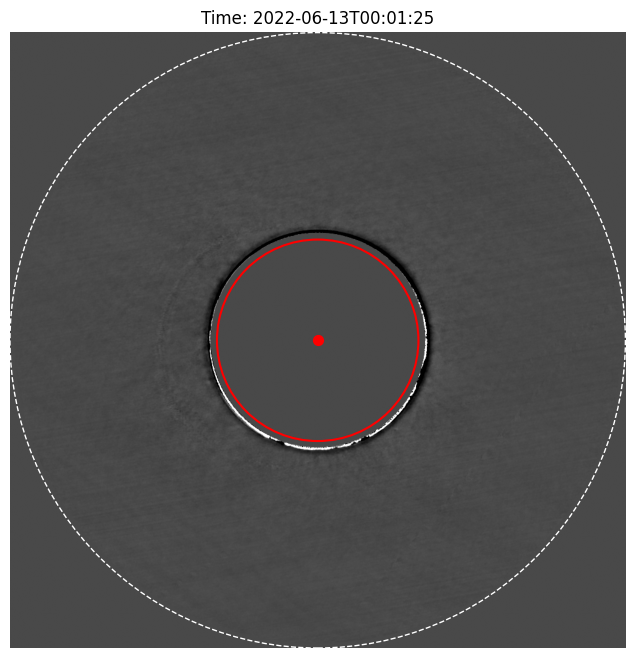

In [13]:
# フォルダー内のFITSファイルを取得
folder_path = "/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/Raw data"
fts_files = sorted(glob.glob(os.path.join(folder_path, "*.fts")))

# アニメーション作成
fig, ax = plt.subplots(figsize=(8, 8))

def update_frame(i):
    """アニメーションフレームを更新."""
    data, header = read_fits_file(fts_files[i])
    return [draw_frame(data, header, ax)]

ani = FuncAnimation(
    fig,
    update_frame,
    frames=len(fts_files),
    interval=15000 / len(fts_files),  # 15秒間隔に調整
)

# 動画の保存
output_path = "/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/Subtraction_animation.mp4"
ani.save(output_path, writer='ffmpeg', fps=5)

print(f"Animation saved to {output_path}")

Animation saved to /home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/Subtraction_animation.mp4


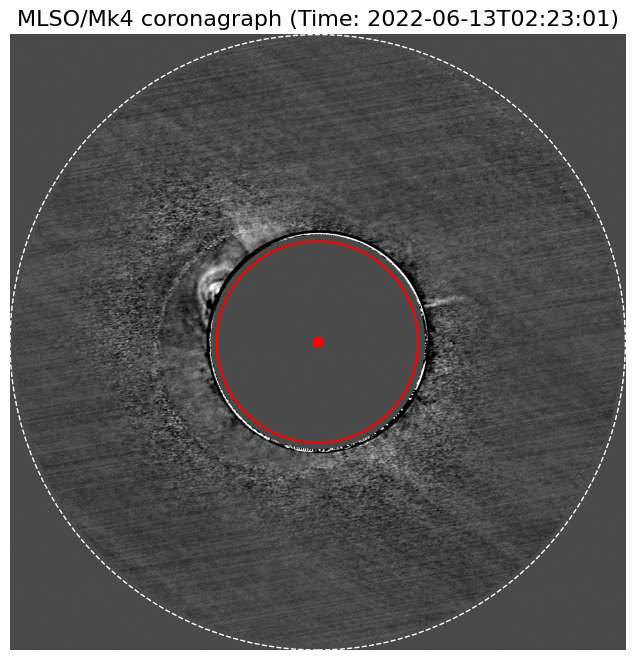

In [20]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.pyplot as plt
import glob, os
import numpy as np
from astropy.io import fits
from matplotlib.patches import Circle

# --- 定義済み関数群 ---
def read_fits_file(fits_path):
    """FITSファイルを読み込み、データとヘッダーを返す."""
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def calculate_statistics(data, exclude_zeros=False):
    """データの統計情報を計算."""
    if exclude_zeros:
        data = data[data > 0]  # ゼロ以下を除外
    return {
        "min": np.min(data),
        "max": np.max(data),
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data),
    }

def draw_frame(data, header, ax):
    """単一フレームを描画."""
    # 太陽中心と半径
    solar_x = header.get('CRPIX1', data.shape[1] // 2) - 1
    solar_y = header.get('CRPIX2', data.shape[0] // 2) - 1
    solar_radius = header.get('R_SUN', 0)

    # ピクセルスケールを太陽半径に変換
    pixel_to_rsun = 1 / solar_radius if solar_radius > 0 else 1

    # データの統計情報を計算
    stats = calculate_statistics(data)
    data_mean, data_std = stats["mean"], stats["std"]
    custom_vmin = data_mean - 2 * data_std
    custom_vmax = data_mean + 5 * data_std

    # 軸の設定
    extent = [
        -solar_x * pixel_to_rsun, (data.shape[1] - solar_x) * pixel_to_rsun,
        -solar_y * pixel_to_rsun, (data.shape[0] - solar_y) * pixel_to_rsun
    ]
    ax.clear()
    ax.imshow(data, cmap='gray', origin='lower', vmin=custom_vmin, vmax=custom_vmax, extent=extent)

    # 太陽中心と円を描画
    ax.scatter(0, 0, color='red', s=50, label="Solar Center")
    if solar_radius > 0:
        circle = Circle((0, 0), solar_radius * pixel_to_rsun, color='red', fill=False, lw=1.5, label="Solar Disk")
        ax.add_patch(circle)
    # 特定の座標を通る円の描画
    custom_radius = np.sqrt((0 - solar_x) ** 2 + (solar_y - solar_y) ** 2) * pixel_to_rsun
    circle_custom = Circle((0, 0), custom_radius, color='white', fill=False, linestyle='--', lw=1.0, label="Custom Radius")
    ax.add_patch(circle_custom)

    # グリッドの描画 (0.5 Rsごと)
    grid_spacing = 0.5
    x_min, x_max = int(extent[0] // grid_spacing) * grid_spacing, int(extent[1] // grid_spacing) * grid_spacing
    y_min, y_max = int(extent[2] // grid_spacing) * grid_spacing, int(extent[3] // grid_spacing) * grid_spacing
    ax.set_xticks(np.arange(x_min+grid_spacing, x_max + grid_spacing, grid_spacing))
    ax.set_yticks(np.arange(y_min+grid_spacing, y_max + grid_spacing, grid_spacing))
    ax.grid(color='white', linestyle='--', linewidth=0.1)

    # タイトルと軸ラベル
    date_obs = header.get('DATE-OBS', 'Unknown Time')
    ax.set_title(f"MLSO/Mk4 coronagraph (Time: {date_obs})", fontsize=16)
    ax.axis('off')
    
    return ax

# --- FITSファイルの取得 ---
folder_path = "/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/Raw data"
fts_files = sorted(glob.glob(os.path.join(folder_path, "*.fts")))

# --- アニメーション作成 ---
fig, ax = plt.subplots(figsize=(8, 8))

def update_frame(i):
    data, header = read_fits_file(fts_files[i])
    draw_frame(data, header, ax)
    return [ax]

ani = FuncAnimation(
    fig,
    update_frame,
    frames=len(fts_files),
    interval=15000 / len(fts_files),
)

# --- FFMpegWriter を使って動画保存 ---
output_path = "/home/kinno-7010/Research/MK4 Coronagraph/MK4 coronagraph_K-COR data/Subtraction data/output/Subtraction_animation.mp4"
writer = FFMpegWriter(fps=5)
ani.save(output_path, writer=writer)

print(f"Animation saved to {output_path}")


## Test

ZeroDivisionError: division by zero

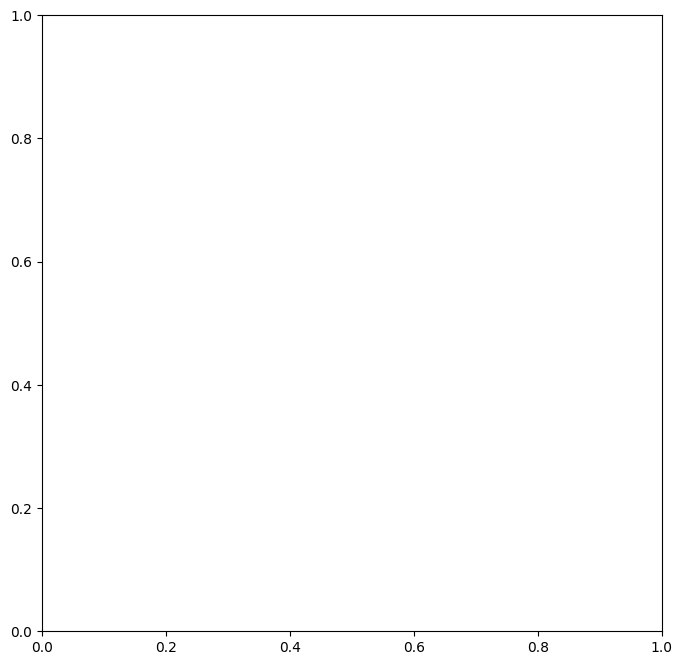

In [9]:
def draw_frame(data, header, ax):
    """単一フレームを描画."""
    # 太陽中心と半径
    solar_x = header.get('CRPIX1', data.shape[1] // 2) - 1
    solar_y = header.get('CRPIX2', data.shape[0] // 2) - 1
    solar_radius = header.get('R_SUN', 0)

    # ピクセルスケールを太陽半径に変換
    pixel_to_rsun = 1 / solar_radius if solar_radius > 0 else 1

    # データの統計情報を計算
    stats = calculate_statistics(data)
    data_mean, data_std = stats["mean"], stats["std"]
    custom_vmin = 0
    custom_vmax = data_mean + 5 * data_std


    # 軸の設定
    extent = [
        -solar_x * pixel_to_rsun, (data.shape[1] - solar_x) * pixel_to_rsun,
        -solar_y * pixel_to_rsun, (data.shape[0] - solar_y) * pixel_to_rsun
    ]
    ax.clear()
    im = ax.imshow(data, cmap='gray', origin='lower', vmin=custom_vmin, vmax=custom_vmax, extent=extent)

    # 太陽中心と円を描画
    ax.scatter(0, 0, color='red', s=50, label="Solar Center")
    if solar_radius > 0:
        circle = Circle((0, 0), solar_radius * pixel_to_rsun, color='red', fill=False, lw=1.5, label="Solar Disk")
        ax.add_patch(circle)
        
        # 特定の座標を通る円の描画
    custom_radius = np.sqrt((0 - solar_x) ** 2 + (solar_y - solar_y) ** 2) * pixel_to_rsun
    circle = Circle((0, 0), custom_radius, color='white', fill=False, linestyle='--', lw=1.0, label="Custom Radius")
    ax.add_patch(circle)

    # グリッドの描画 (0.5 Rsごと)
    grid_spacing = 0.5
    x_min, x_max = int(extent[0] // grid_spacing) * grid_spacing, int(extent[1] // grid_spacing) * grid_spacing
    y_min, y_max = int(extent[2] // grid_spacing) * grid_spacing, int(extent[3] // grid_spacing) * grid_spacing
    ax.set_xticks(np.arange(x_min+grid_spacing, x_max + grid_spacing, grid_spacing))
    ax.set_yticks(np.arange(y_min+grid_spacing, y_max + grid_spacing, grid_spacing))
    ax.grid(color='white', linestyle='--', linewidth=0.1)

    # タイトルと軸ラベル
    file_name = os.path.basename(header.get('FILENAME', ''))
    date_obs = header.get('DATE-OBS', 'Unknown Time')  # 観測時間を取得
    ax.set_title(f"Time: {date_obs}", fontsize=12)  # タイトルに観測時間を表示
    ax.set_xlabel("X [Solar Radius $R_\\odot$]", fontsize=10)
    ax.set_ylabel("Y [Solar Radius $R_\\odot$]", fontsize=10)

    return im

# フォルダー内のFITSファイルを取得
folder_path = "/home/kinno-7010/Document/Iwai2020event/FITS file/K-COR data/White Light Level-2 Pb Data"
fts_files = sorted(glob.glob(os.path.join(folder_path, "*.fts")))

# アニメーション作成
fig, ax = plt.subplots(figsize=(8, 8))

def update_frame(i):
    """アニメーションフレームを更新."""
    data, header = read_fits_file(fts_files[i])
    return [draw_frame(data, header, ax)]

ani = FuncAnimation(
    fig,
    update_frame,
    frames=len(fts_files),
    interval=15000 / len(fts_files),  # 15秒間隔に調整
)

# 動画の保存
output_path = "/home/kinno-7010/Document/Iwai2020event/kcor_animation.mp4"
ani.save(output_path, writer='ffmpeg', fps=10)

print(f"Animation saved to {output_path}")

Animation saved to /home/kinno-7010/Document/Iwai2020event/kcor_animation.mp4


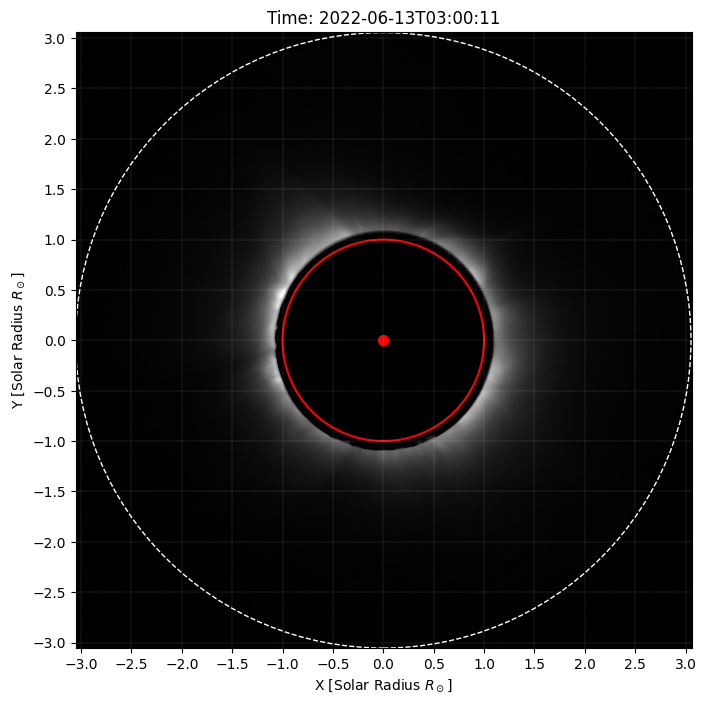

In [8]:
def read_fits_file(fits_path):
    """FITSファイルを読み込み、データとヘッダーを返す."""
    with fits.open(fits_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def calculate_statistics(data, exclude_zeros=False):
    """データの統計情報を計算."""
    if exclude_zeros:
        data = data[data > 0]  # ゼロ以下を除外
    return {
        "min": np.min(data),
        "max": np.max(data),
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data),
    }

def draw_frame(data, header, ax):
    """単一フレームを描画."""
    # 太陽中心と半径
    solar_x = header.get('CRPIX1', data.shape[1] // 2) - 1
    solar_y = header.get('CRPIX2', data.shape[0] // 2) - 1
    solar_radius = header.get('R_SUN', 0)

    # ピクセルスケールを太陽半径に変換
    pixel_to_rsun = 1 / solar_radius if solar_radius > 0 else 1

    # データの統計情報を計算
    stats = calculate_statistics(data)
    data_min, data_max, data_mean,data_median, data_std = stats["min"], stats["max"], stats["mean"], stats["median"], stats["std"]
    custom_vmin = -8e-9
    custom_vmax = 9e-7
    # print("data_min:", data_min)
    # print("data_max:", data_max)
    # print("data_mean:", data_mean)
    # print("data_median:", data_median)
    # print("data_std:", data_std)
    

    # 軸の設定
    extent = [
        -solar_x * pixel_to_rsun, (data.shape[1] - solar_x) * pixel_to_rsun,
        -solar_y * pixel_to_rsun, (data.shape[0] - solar_y) * pixel_to_rsun
    ]
    ax.clear()
    im = ax.imshow(data, cmap='gray', origin='lower', vmin=custom_vmin, vmax=custom_vmax, extent=extent)

    # 太陽中心と円を描画
    ax.scatter(0, 0, color='red', s=50, label="Solar Center")
    if solar_radius > 0:
        circle = Circle((0, 0), solar_radius * pixel_to_rsun, color='red', fill=False, lw=1.5, label="Solar Disk")
        ax.add_patch(circle)
        
        # 特定の座標を通る円の描画
    custom_radius = np.sqrt((0 - solar_x) ** 2 + (solar_y - solar_y) ** 2) * pixel_to_rsun
    circle = Circle((0, 0), custom_radius, color='white', fill=False, linestyle='--', lw=1.0, label="Custom Radius")
    ax.add_patch(circle)

    # グリッドの描画 (0.5 Rsごと)
    grid_spacing = 0.5
    x_min, x_max = int(extent[0] // grid_spacing) * grid_spacing, int(extent[1] // grid_spacing) * grid_spacing
    y_min, y_max = int(extent[2] // grid_spacing) * grid_spacing, int(extent[3] // grid_spacing) * grid_spacing
    ax.set_xticks(np.arange(x_min+grid_spacing, x_max + grid_spacing, grid_spacing))
    ax.set_yticks(np.arange(y_min+grid_spacing, y_max + grid_spacing, grid_spacing))
    ax.grid(color='white', linestyle='--', linewidth=0.1)

    # タイトルと軸ラベル
    file_name = os.path.basename(header.get('FILENAME', ''))
    date_obs = header.get('DATE-OBS', 'Unknown Time')  # 観測時間を取得
    ax.set_title(f"Time: {date_obs}", fontsize=12)  # タイトルに観測時間を表示
    ax.set_xlabel("X [Solar Radius $R_\\odot$]", fontsize=10)
    ax.set_ylabel("Y [Solar Radius $R_\\odot$]", fontsize=10)

    return im

# フォルダー内のFITSファイルを取得
folder_path = "/home/kinno-7010/Document/Iwai2020event/FITS file/K-COR data/White Light Level-2 Pb Data"
fts_files = sorted(glob.glob(os.path.join(folder_path, "*.fts")))

# アニメーション作成
fig, ax = plt.subplots(figsize=(8, 8))

def update_frame(i):
    """アニメーションフレームを更新."""
    data, header = read_fits_file(fts_files[i])
    return [draw_frame(data, header, ax)]

ani = FuncAnimation(
    fig,
    update_frame,
    frames=len(fts_files),
    interval=15000 / len(fts_files),  # 15秒間隔に調整
)

# 動画の保存
output_path = "/home/kinno-7010/Document/Iwai2020event/kcor_animation.mp4"
ani.save(output_path, writer='ffmpeg', fps=10)

print(f"Animation saved to {output_path}")

Statistics: {'min': np.float32(2.9689975e-14), 'max': np.float32(9.1430127e-07), 'mean': np.float32(5.6226565e-08), 'median': np.float32(1.2109165e-08), 'std': np.float32(1.0516418e-07)}
fts_files[0]: /home/kinno-7010/Document/Iwai2020event/FITS file/K-COR data/White Light Level-2 Pb Data/20220613_030011_kcor_l2.fts


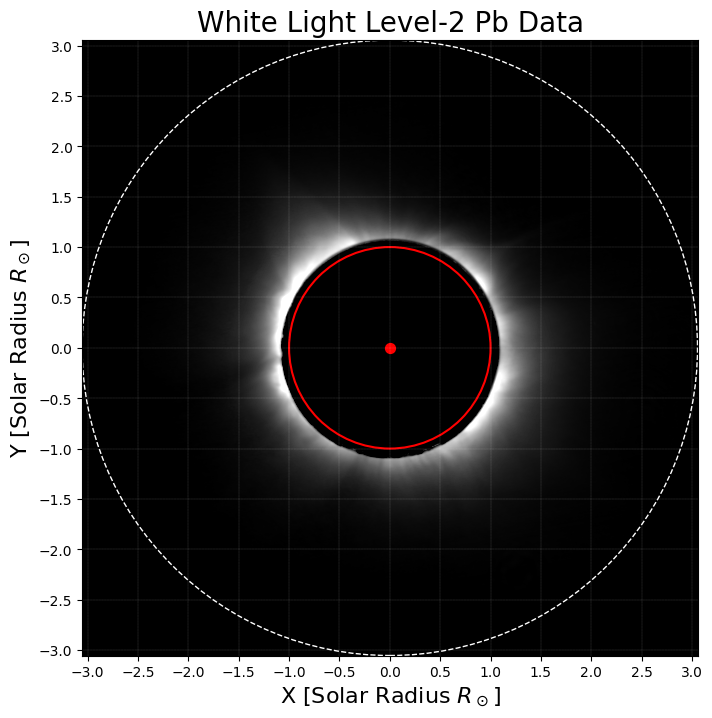

In [211]:

# 2. 最初のFITSファイルを読み込む
if fts_files:
    data, header = read_fits_file(fts_files[0])

    # 3. 統計情報の計算
    stats = calculate_statistics(data)
    print(f"Statistics:", stats)
    print("fts_files[0]:", fts_files[0])

    # 4. 可視化
    visualize_fits_data(data, header, stats)

### memo

In [3]:
import tarfile

file_path = '/home/kinno-7010/Document/Iwai2020event/FITS file/K-COR data/White Light Level-2 Pb Data/20220613.kcor_nrgf.fits.tar'

# アーカイブ内容を確認
with tarfile.open(file_path, 'r') as tar:
    print("Files in the archive:")
    for member in tar.getmembers():
        print(member.name)


Files in the archive:
20220613_030011_kcor_l2_nrgf.fts.gz
20220613_030027_kcor_l2_nrgf.fts.gz
20220613_030042_kcor_l2_nrgf.fts.gz
20220613_030057_kcor_l2_nrgf.fts.gz
20220613_030112_kcor_l2_nrgf.fts.gz
20220613_030127_kcor_l2_nrgf.fts.gz
20220613_030142_kcor_l2_nrgf.fts.gz
20220613_030158_kcor_l2_nrgf.fts.gz
20220613_030213_kcor_l2_nrgf.fts.gz
20220613_030228_kcor_l2_nrgf.fts.gz
20220613_030243_kcor_l2_nrgf.fts.gz
20220613_030258_kcor_l2_nrgf.fts.gz
20220613_030313_kcor_l2_nrgf.fts.gz
20220613_030329_kcor_l2_nrgf.fts.gz
20220613_030344_kcor_l2_nrgf.fts.gz
20220613_030359_kcor_l2_nrgf.fts.gz
20220613_030414_kcor_l2_nrgf.fts.gz
20220613_030429_kcor_l2_nrgf.fts.gz
20220613_030445_kcor_l2_nrgf.fts.gz
20220613_030500_kcor_l2_nrgf.fts.gz
20220613_030515_kcor_l2_nrgf.fts.gz
20220613_030530_kcor_l2_nrgf.fts.gz
20220613_030545_kcor_l2_nrgf.fts.gz
20220613_030600_kcor_l2_nrgf.fts.gz
20220613_030616_kcor_l2_nrgf.fts.gz
20220613_030631_kcor_l2_nrgf.fts.gz
20220613_030646_kcor_l2_nrgf.fts.gz
202206

In [4]:
import os

# サブディレクトリを含む全ファイルを探索
fits_files = []
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if file.endswith('.fits'):
            fits_files.append(os.path.join(root, file))

print("Found FITS files:", fits_files)


Found FITS files: []


In [5]:
fits_files = []
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if file.endswith(('.fits', '.fit', '.fts')):
            fits_files.append(os.path.join(root, file))

print("Found FITS files:", fits_files)


Found FITS files: []


In [6]:
import tarfile

try:
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_folder)
        print(f"Files successfully extracted to: {extract_folder}")
except Exception as e:
    print(f"Error during extraction: {e}")


Files successfully extracted to: /home/kinno-7010/Document/Iwai2020event/FITS file/K-COR data/White Light Level-2 Pb Data
